In [57]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [58]:
df = pd.read_csv('/Users/sachacollinson/Downloads/fake_transactional_data_24.csv')
df = df.rename(columns={"from_totally_fake_account": "AccountNumber", "monopoly_money_amount": "MoneyTransferAmount", "to_randomly_generated_account": "TransferredLocationAccount", "not_happened_yet_date": "TransactionDate"})
# from_totally_fake_account  = AccountNumber
# monopoly_money_amount = MoneyTransferAmount
# to_randomly_generated_account = TransferredLocationAccount
# not_happened_yet_date = TransactionDate
df_NonNumeric_Mapping = pd.read_excel('/Users/sachacollinson/Downloads/Location_value_pairs.xlsx')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format="%d/%m/%Y").dt.date
df = df.sort_values(by=['TransactionDate'])

df_Transferred_numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric())].copy()
df_Transferred_Non_Numeric = df[df['TransferredLocationAccount'].apply(lambda x: str(x).isnumeric()==False)].copy()

In [82]:
df_NonNumeric_Mapping['Key'] = df_NonNumeric_Mapping['Key'].str.strip()
mapping_dict = df_NonNumeric_Mapping.to_dict(orient='records')
mapped_dict = {entry['Key']: entry['Value'] for entry in mapping_dict}

# # Create a new column by mapping values from the 'key' column using the mapping dictionary
df_Transferred_Non_Numeric['CategoryTransferredLocationAccount'] = df_Transferred_Non_Numeric['TransferredLocationAccount'].map(mapped_dict)

# # Print the DataFrame with the new column
print(len(df_Transferred_numeric))
print(len(df_Transferred_Non_Numeric))
print(len(df))

frames = [df_Transferred_Non_Numeric,df_Transferred_numeric]
df2 = pd.concat(frames)
df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)
print(df2)


2532763
7615517
10148280


/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_41513/2160608980.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['CategoryTransferredLocationAccount'].fillna('Numeric', inplace=True)


          AccountNumber  MoneyTransferAmount TransferredLocationAccount  \
0               10371.0                 4.00                     CINEMA   
13385           98994.0                 2.65                COFFEE_SHOP   
13384           98994.0                 2.20        A_LOCAL_COFFEE_SHOP   
13383           34189.0                14.50                        BAR   
13382           86417.0                 4.35                COFFEE_SHOP   
...                 ...                  ...                        ...   
10137320        41950.0                 6.00                      21887   
10137322         8097.0                 5.00                      84802   
10137336        99012.0                 6.50                      27845   
10137340        60186.0                 2.65                      35802   
10137248        42065.0                 6.00                      83201   

         TransactionDate CategoryTransferredLocationAccount  
0             2025-01-01             

In [83]:
# Ensure TransactionDate is in datetime format
df2['TransactionDate'] = pd.to_datetime(df['TransactionDate'], dayfirst=True)  # Adjusting for day-first format
end_date = pd.Timestamp('2025-12-31')

# RFM Calculation
rfm = df2.groupby('AccountNumber').agg({
    'TransactionDate': lambda x: (end_date - x.max()).days,
    'AccountNumber': 'count',
    'MoneyTransferAmount': 'sum'
}).rename(columns={'TransactionDate': 'Recency',
                   'AccountNumber': 'Frequency',
                   'MoneyTransferAmount': 'MonetaryValue'})

# Scoring RFM values
# Quantiles can be adjusted as needed
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()

def rfm_score(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

# Apply the scoring
rfm['R_Score'] = rfm['Recency'].apply(rfm_score, args=('Recency', quantiles,))
rfm['F_Score'] = rfm['Frequency'].apply(lambda x: 4 if x <= quantiles['Frequency'][0.25] else 3 if x <= quantiles['Frequency'][0.50] else 2 if x <= quantiles['Frequency'][0.75] else 1)
rfm['M_Score'] = rfm['MonetaryValue'].apply(rfm_score, args=('MonetaryValue', quantiles,))

# Combine RFM scores
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Display the final RFM segmentation
print(rfm.head())

               Recency  Frequency  MonetaryValue  R_Score  F_Score  M_Score  \
AccountNumber                                                                 
1000.0               0       1710       28698.51        1        1        3   
1002.0               0       1043       15622.97        1        3        1   
1006.0               0       1841       18778.19        1        1        2   
1018.0               1        805       15612.21        4        4        1   
1053.0               0       1319       19444.57        1        2        2   

              RFM_Score  
AccountNumber            
1000.0              113  
1002.0              131  
1006.0              112  
1018.0              441  
1053.0              122  


In [84]:
rfm.describe()

,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score
count,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000
mean,0.273397,1246.411201,22925.845676,1.571481,2.501474,2.500000
std,0.641999,346.909076,6811.697500,1.178144,1.118212,1.118213
min,0.000000,436.000000,8079.130000,1.000000,1.000000,1.000000
25%,0.000000,989.000000,17699.610000,1.000000,2.000000,1.250000
50%,0.000000,1154.000000,21021.590000,1.000000,3.000000,2.500000
75%,0.000000,1500.000000,28918.547500,1.000000,4.000000,3.750000
max,4.000000,2728.000000,45141.370000,4.000000,4.000000,4.000000


All customers are very recent (the max period since last transaction is 4 days) may be worth not putting as much emphasis on this score. 

In [85]:
# Count the number of customers in each segment
rfm_count = rfm['RFM_Score'].value_counts().reset_index()
rfm_count.columns = ['RFM_Score', 'Count']



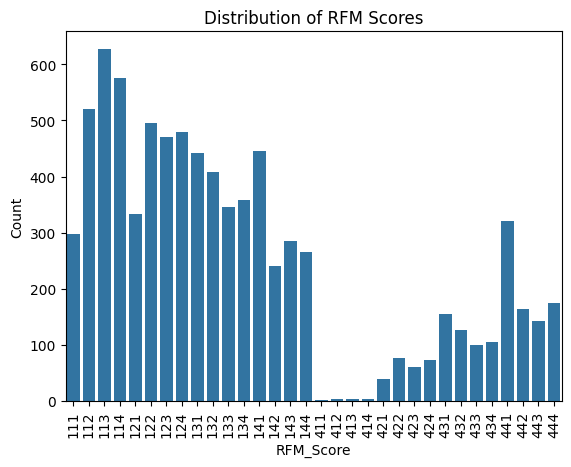

In [86]:
# Plotting the distribution of customers across RFM scores
sns.barplot(x='RFM_Score', y='Count', data=rfm_count.sort_values('RFM_Score'))
plt.title('Distribution of RFM Scores')
plt.xticks(rotation=90)  # Rotates labels to make them readable
plt.show()

As said previously, majority of the customers are in 1** part of the graph 

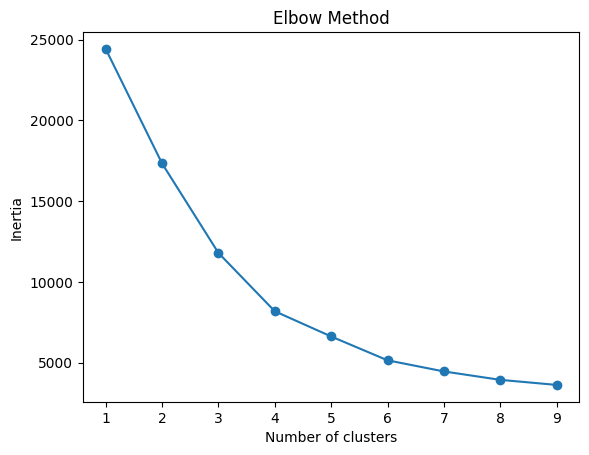

In [87]:
# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'MonetaryValue']])

# Determine the optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [88]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Examine cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Recency', 'Frequency', 'MonetaryValue'])
print(centroids)

# Analyze cluster characteristics
for cluster in sorted(rfm['Cluster'].unique()):
    print(f"\nCluster {cluster} Characteristics:")
    cluster_data = rfm[rfm['Cluster'] == cluster]
    print(cluster_data.describe())

    Recency    Frequency  MonetaryValue
0  0.002317  1292.060950   18835.682806
1  0.072240  1322.724432   31446.925511
2  1.495231   963.935437   20470.315275

Cluster 0 Characteristics:
           Recency    Frequency  MonetaryValue      R_Score      F_Score  \
count  4317.000000  4317.000000    4317.000000  4317.000000  4317.000000   
mean      0.002316  1292.581886   18838.109217     1.006949     2.340283   
std       0.048079   337.274862    3111.314440     0.144237     1.089499   
min       0.000000   524.000000    8079.130000     1.000000     1.000000   
25%       0.000000  1035.000000   16687.880000     1.000000     1.000000   
50%       0.000000  1205.000000   18889.580000     1.000000     2.000000   
75%       0.000000  1573.000000   21126.010000     1.000000     3.000000   
max       1.000000  2619.000000   25751.480000     4.000000     4.000000   

           M_Score  Cluster  
count  4317.000000   4317.0  
mean      1.908270      0.0  
std       0.777891      0.0  
min    

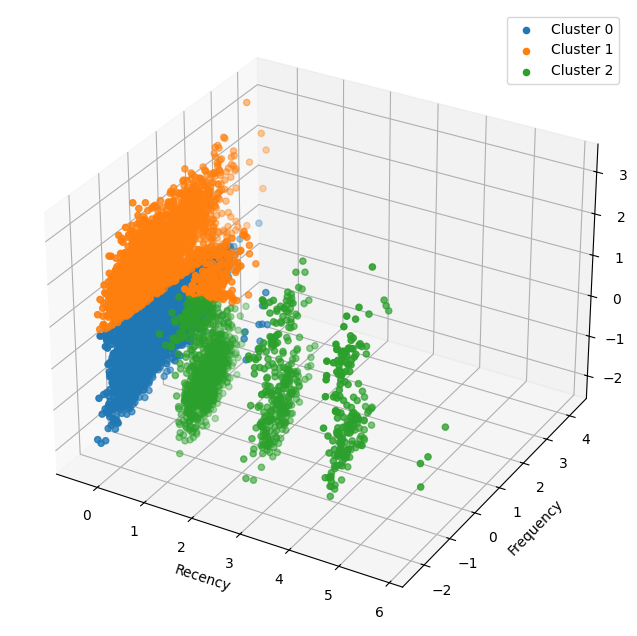

In [89]:
# Assuming rfm_scaled is your standardized RFM data and it has a 'Cluster' column for cluster labels
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(kmeans.n_clusters):
    ax.scatter(rfm_scaled[rfm['Cluster'] == i, 0], rfm_scaled[rfm['Cluster'] == i, 1], rfm_scaled[rfm['Cluster'] == i, 2], label=f'Cluster {i}')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend()
plt.show()

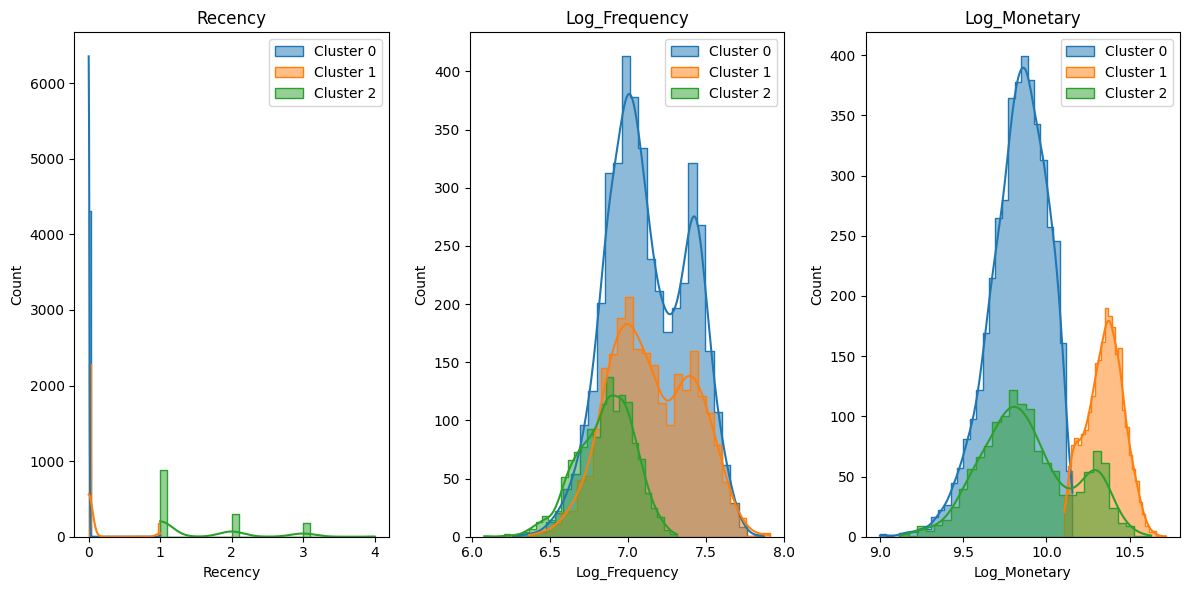

In [90]:
# Apply log transformation to 'Frequency' and 'Monetary' to handle wide ranges
rfm['Log_Frequency'] = np.log1p(rfm['Frequency'])
rfm['Log_Monetary'] = np.log1p(rfm['MonetaryValue'])

fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Increased figure size
axes = axes.flatten()

features = ['Recency', 'Log_Frequency', 'Log_Monetary']
for i, feature in enumerate(features):
    for cluster in range(kmeans.n_clusters):
        # Adjust bin size for better visualization
        sns.histplot(rfm[rfm['Cluster'] == cluster][feature], ax=axes[i], label=f'Cluster {cluster}', kde=True, bins=30, element='step')
    axes[i].set_title(feature)
    axes[i].legend()

plt.tight_layout()
plt.show()

Cluster 0 (Blue) - All very recent. Frequency peaks around lower end with lesser peak extending to higher values. Lots of monetary values around 9.5-10 range.

Cluster 1 (Orange) - Peak at moderate frequency values. Narrow peak in Monetary on  the higher end - suggesting more consistancy and spending higher on average

Cluster 2 (Green) - Lower range of frequency, lowest spending (peak at lower end of monetary scale)

In [91]:
for cluster in range(kmeans.n_clusters):
    print(f'\nCluster {cluster} Statistics:')
    display(rfm[rfm['Cluster'] == cluster].describe())


Cluster 0 Statistics:


,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,Cluster,Log_Frequency,Log_Monetary
count,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.000000,4317.0,4317.000000,4317.000000
mean,0.002316,1292.581886,18838.109217,1.006949,2.340283,1.908270,0.0,7.131868,9.829167
std,0.048079,337.274862,3111.314440,0.144237,1.089499,0.777891,0.0,0.257787,0.173780
min,0.000000,524.000000,8079.130000,1.000000,1.000000,1.000000,0.0,6.263398,8.997163
25%,0.000000,1035.000000,16687.880000,1.000000,1.000000,1.000000,0.0,6.943122,9.722498
50%,0.000000,1205.000000,18889.580000,1.000000,2.000000,2.000000,0.0,7.095064,9.846419
75%,0.000000,1573.000000,21126.010000,1.000000,3.000000,3.000000,0.0,7.361375,9.958308
max,1.000000,2619.000000,25751.480000,4.000000,4.000000,3.000000,0.0,7.870930,10.156286



Cluster 1 Statistics:


,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,Cluster,Log_Frequency,Log_Monetary
count,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.0,2463.000000,2463.000000
mean,0.072676,1321.720260,31452.523082,1.218027,2.270402,3.751117,1.0,7.151415,10.350092
std,0.259656,359.173042,3493.149171,0.778968,1.093499,0.432454,0.0,0.268164,0.111309
min,0.000000,581.000000,24508.270000,1.000000,1.000000,3.000000,1.0,6.366470,10.106807
25%,0.000000,1037.000000,28935.255000,1.000000,1.000000,4.000000,1.0,6.945051,10.272851
50%,0.000000,1244.000000,31475.870000,1.000000,2.000000,4.000000,1.0,7.126891,10.357008
75%,0.000000,1594.000000,33827.510000,1.000000,3.000000,4.000000,1.0,7.374629,10.429059
max,1.000000,2728.000000,45141.370000,4.000000,4.000000,4.000000,1.0,7.911691,10.717577



Cluster 2 Statistics:


,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,Cluster,Log_Frequency,Log_Monetary
count,1362.000000,1362.000000,1362.000000,1362.0,1362.000000,1362.000000,1362.0,1362.000000,1362.000000
mean,1.495595,963.881791,20462.961564,4.0,3.430250,2.113069,2.0,6.855960,9.887709
std,0.731607,169.866443,5841.842781,0.0,0.714021,1.062550,0.0,0.181452,0.276202
min,1.000000,436.000000,9143.510000,4.0,2.000000,1.000000,2.0,6.079933,9.120909
25%,1.000000,839.250000,16246.070000,4.0,3.000000,1.000000,2.0,6.733699,9.695668
50%,1.000000,966.000000,18990.980000,4.0,4.000000,2.000000,2.0,6.874198,9.851772
75%,2.000000,1082.000000,23692.827500,4.0,4.000000,3.000000,2.0,6.987490,10.072970
max,4.000000,1499.000000,41324.600000,4.0,4.000000,4.000000,2.0,7.313220,10.629237


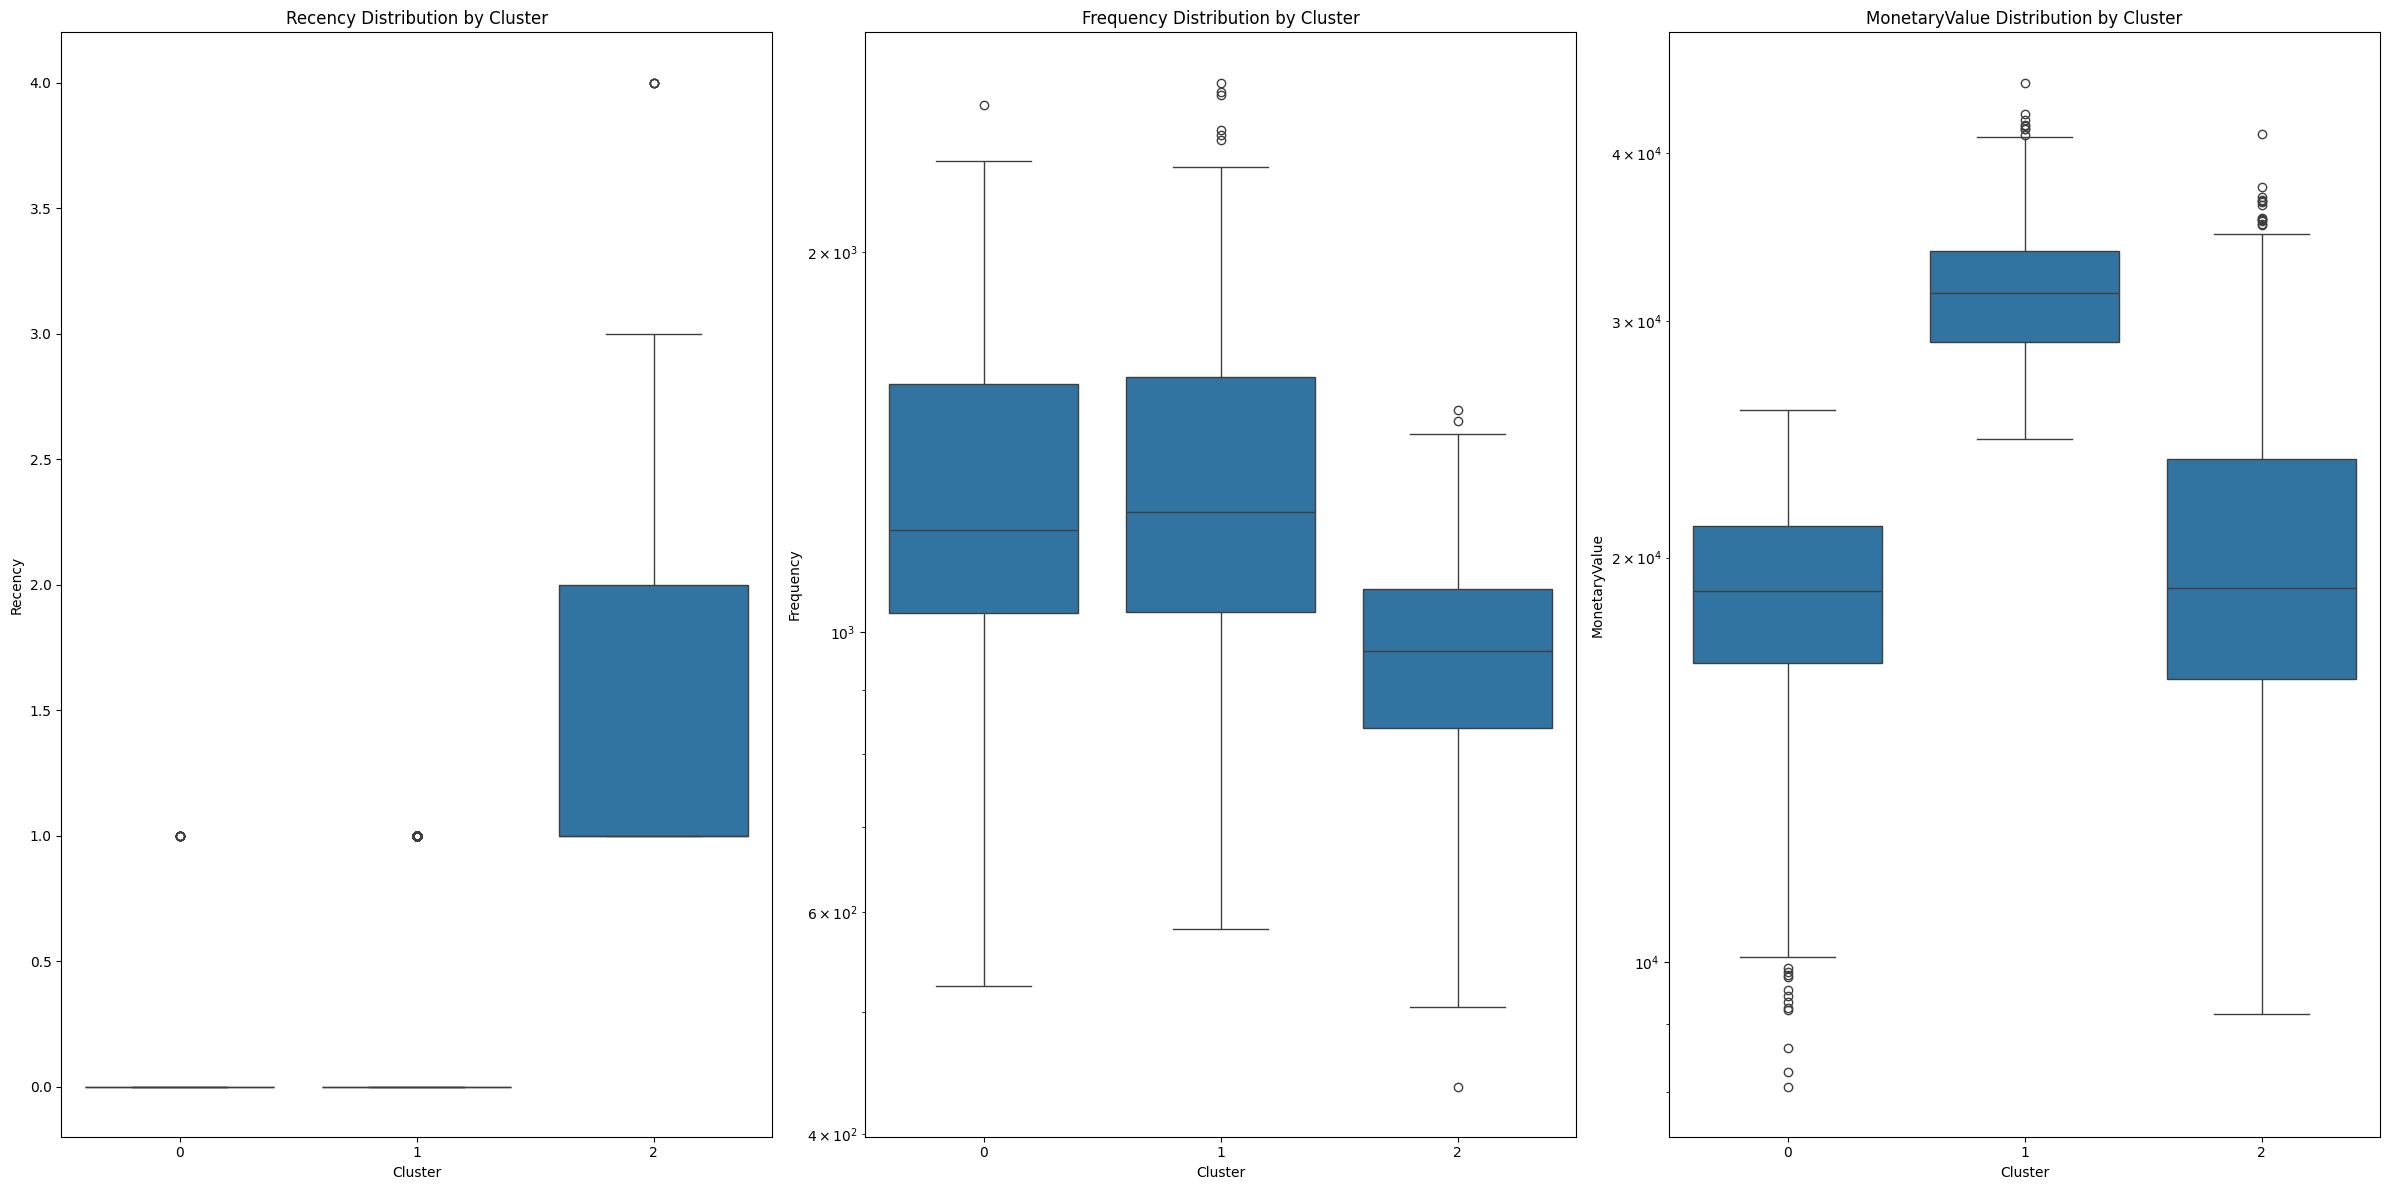

In [92]:
features = ['Recency', 'Frequency', 'MonetaryValue']
fig, axes = plt.subplots(1, 3, figsize=(24, 12))  # Adjust the size as needed

for i, feature in enumerate(features):
    sns.boxplot(x='Cluster', y=feature, data=rfm, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Cluster')
    # Optional: To improve readability, you might log-transform Frequency and Monetary values
    if feature in ['Frequency', 'MonetaryValue']:
        axes[i].set_yscale('log')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [93]:
print(rfm)

               Recency  Frequency  MonetaryValue  R_Score  F_Score  M_Score  \
AccountNumber                                                                 
1000.0               0       1710       28698.51        1        1        3   
1002.0               0       1043       15622.97        1        3        1   
1006.0               0       1841       18778.19        1        1        2   
1018.0               1        805       15612.21        4        4        1   
1053.0               0       1319       19444.57        1        2        2   
...                ...        ...            ...      ...      ...      ...   
100931.0             0       1664       22332.81        1        1        3   
100934.0             1       1111       18579.25        4        3        2   
100947.0             0       1586       20783.20        1        1        2   
100986.0             0       1034       15314.23        1        3        1   
100988.0             0       1351       19714.77    

In [94]:
merged_df = pd.merge(df2, rfm, on='AccountNumber', how='left')

print(merged_df)

          AccountNumber  MoneyTransferAmount TransferredLocationAccount  \
0               10371.0                 4.00                     CINEMA   
1               98994.0                 2.65                COFFEE_SHOP   
2               98994.0                 2.20        A_LOCAL_COFFEE_SHOP   
3               34189.0                14.50                        BAR   
4               86417.0                 4.35                COFFEE_SHOP   
...                 ...                  ...                        ...   
10148275        41950.0                 6.00                      21887   
10148276         8097.0                 5.00                      84802   
10148277        99012.0                 6.50                      27845   
10148278        60186.0                 2.65                      35802   
10148279        42065.0                 6.00                      83201   

         TransactionDate CategoryTransferredLocationAccount  Recency  \
0             2025-01-01   

/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_41513/738185343.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_41513/738185343.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_monetary_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_41513/738185343.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
/var/folders/2l/zb5_xmsx54x0g2sb6y63xcsw0000gn/T/ipykernel_4

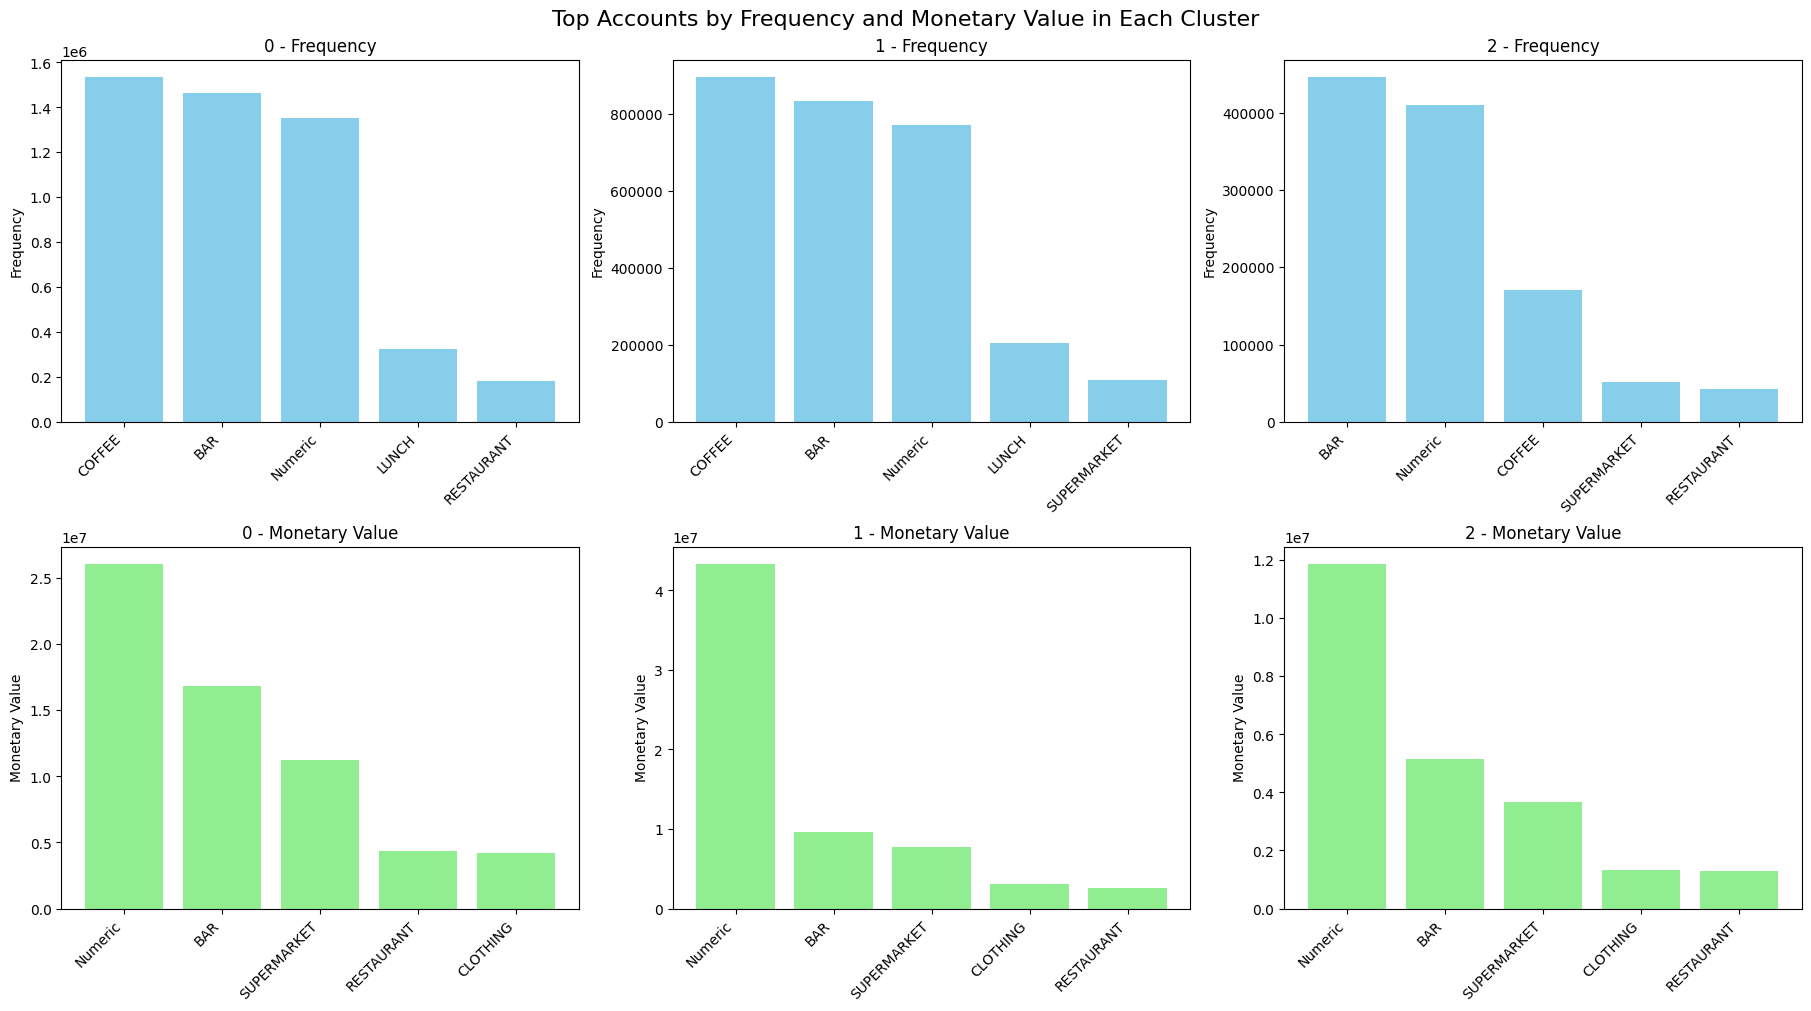

In [96]:
# Aggregating data for frequency and monetary value by cluster and account
frequency_df = merged_df.groupby(['Cluster', 'CategoryTransferredLocationAccount']).size().reset_index(name='Frequency')
monetary_df = merged_df.groupby(['Cluster', 'CategoryTransferredLocationAccount'])['MoneyTransferAmount'].sum().reset_index(name='MonetaryValue')

# Sorting for top accounts in each cluster by frequency
top_frequency_df = frequency_df.sort_values(by=['Cluster', 'Frequency'], ascending=[True, False]).groupby('Cluster').head(5)

# Sorting for top accounts in each cluster by monetary value
top_monetary_df = monetary_df.sort_values(by=['Cluster', 'MonetaryValue'], ascending=[True, False]).groupby('Cluster').head(5)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), constrained_layout=True)
fig.suptitle('Top Accounts by Frequency and Monetary Value in Each Cluster', fontsize=16)

clusters = merged_df['Cluster'].unique()
for i, cluster in enumerate(sorted(clusters)):
    # Frequency
    ax = axes[0, i]
    top_freq_cluster = top_frequency_df[top_frequency_df['Cluster'] == cluster]
    ax.bar(top_freq_cluster['CategoryTransferredLocationAccount'], top_freq_cluster['Frequency'], color='skyblue')
    ax.set_title(f'{cluster} - Frequency')
    ax.set_xticklabels(top_freq_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
    ax.set_ylabel('Frequency')

    # Monetary Value
    ax = axes[1, i]
    top_monetary_cluster = top_monetary_df[top_monetary_df['Cluster'] == cluster]
    ax.bar(top_monetary_cluster['CategoryTransferredLocationAccount'], top_monetary_cluster['MonetaryValue'], color='lightgreen')
    ax.set_title(f'{cluster} - Monetary Value')
    ax.set_xticklabels(top_monetary_cluster['CategoryTransferredLocationAccount'], rotation=45, ha="right")
    ax.set_ylabel('Monetary Value')

plt.show()